In [1]:
%matplotlib inline

import collections
from collections import Counter
import random
import matplotlib.pyplot as plt
import nltk
import numpy as np
import torch

# Other Imports
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import math
from tqdm import tqdm
from nltk.tokenize import sent_tokenize

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Text compression assignment

It is said that you can measure the intelligence of an AI from the amount it can compress a text without information loss.
One way to think about this is that, the more a text is predictable, the more words we can leave out of it as we can guess the missing words.
On the other hand, the more intelligent an AI is, the more it will find texts to be predictable and so the more words it can leave out and guess.
This has led to a competition called the [Hutter Prize](http://prize.hutter1.net/) where the objective is to compress a given text as much as possible.
The record for compressing a 1GB text file extracted from a Wikipedia snapshot is about 115MB.
The main hurdle here is that the program used to decompress the file must be treated as part of the compressed file, meaning that the program itself must also be small.

In this assignment, you're going to be doing something similar using a smaller text file and using neural language models to guess missing words.

## 1) Data processing (10%)

You have a train/dev/test split corpus of text from Wikipedia consisting of single sentences.
Each sentence is on a separate line and each sentence has been tokenised for you such that tokens are space separated.
This means that you only need to split by space to get the tokens.
The text has all been lowercased as well.
The objective here is to be able to compress the text losslessly, meaning that it can be decompressed back to the original string:

$$\text{decompress}(\text{compress}(t)) = t$$

Do not do any further pre-processing on the text (such as stemming) as it may result in unrecoverable information loss.
The test set is what we will be compressing and will not be processed at all as it will be treated as a single big string by the compression/decompression algorithms.

Do the following tasks:

1.1) Load the train set and dev set text files into a list of sentences where each sentence is tokenised (by splitting by space).
Do not load the test set.

In [2]:
# Function to load and tokenize sentences from a text file
def load_and_tokenize(file_path):
    # Open the file with read permissions and UTF-8 encoding
    with open(file_path, 'r', encoding='utf-8') as f:
        # Read all lines from the file into a list
        sentences = f.readlines()
    # Return a list of tokenized sentences
    # Each sentence is stripped of leading/trailing whitespaces and then split by spaces
    return [sentence.strip().split(' ') for sentence in sentences]

# Define the paths to the train and dev text files
train_file_path = 'train.txt'
dev_file_path = 'dev.txt'

# Load and tokenize the sentences from the train set
train_sentences = load_and_tokenize(train_file_path)
# Load and tokenize the sentences from the dev set
dev_sentences = load_and_tokenize(dev_file_path)

# Take the first 3 tokenized sentences from the train set as sample data
sample_train = train_sentences[:3]
# Take the first 3 tokenized sentences from the dev set as sample data
sample_dev = dev_sentences[:3]

# Print the sample data from the train set to verify the output
print("Sample Train Sentences:\n\n", sample_train)
# Print the sample data from the dev set to verify the output
print("\nSample Dev Sentences:\n\n", sample_dev)

Sample Train Sentences:

 [['dr.', 'tonie', 'mcdonald', 'is', 'a', 'life', 'long', 'levittown', 'resident', 'who', 'taught', 'and', 'rose', 'through', 'the', 'ranks', 'of', 'the', 'district', 'she', 'now', 'leads', '.'], ['he', 'received', 'his', 'ba', 'in', 'chemistry', ',', 'magna', 'cum', 'laude', ',', 'from', 'amherst', 'college', 'in', '1', '9', '8', '1', '.'], ['the', 'growth', 'of', 'twin', 'cities', 'international', 'airport', 'during', 'the', 'last', 'half', 'of', 'the', 'twentieth', 'century', 'along', 'with', 'additions', 'of', 'land', 'to', 'the', 'fort', 'snelling', 'compound', 'meant', 'further', 'reductions', '.']]

Sample Dev Sentences:

 [['jones', 'viewed', 'the', 'resolution', 'as', 'the', 'framework', ',', 'and', 'not', 'the', 'final', 'solution', ',', 'for', 'enabling', 'librarians', 'to', 'confront', 'issues', 'that', 'hampered', '``', 'human', 'freedom', "''", '.'], ['he', 'lives', 'in', 'ottawa', ',', 'where', 'he', 'composes', 'full-time', '.'], ['many', 'natur

1.2) Extract a vocabulary consisting of the tokens that occur at least 3 times in the train set and output the size of your vocabulary.
Also output the most frequent vocabulary token in the train set, which should be 'the'.
Include the edge token, unknown token, and pad token in the vocabulary.

In [3]:
# Count the frequency of each token in the train set
token_counter = Counter(token for sentence in train_sentences for token in sentence)

# Create a vocabulary by filtering out tokens that appear less than 3 times in the train set
vocab = {token for token, count in token_counter.items() if count >= 3}

# Define a set of special tokens: Padding, Unknown, and Edge tokens
special_tokens = {'<PAD>', '<UNK>', '<EDGE>'}

# Add the special tokens to the vocabulary
vocab.update(special_tokens)

# Convert the vocabulary set to a dictionary with unique integer IDs for each token
vocab_dict = {token: index for index, token in enumerate(vocab)}

# Optionally, create an index-to-token dictionary for reverse look-up
index_to_token = {index: token for token, index in vocab_dict.items()}

# Testing: Check if special tokens are in the vocabulary dictionary
assert '<PAD>' in vocab_dict, "'<PAD>' not found in vocab_dict"
assert '<UNK>' in vocab_dict, "'<UNK>' not found in vocab_dict"
assert '<EDGE>' in vocab_dict, "'<EDGE>' not found in vocab_dict"

# Calculate the size of the vocabulary by taking the length of the vocab dictionary
vocab_size = len(vocab_dict)

# Find the most frequent token in the train set
most_frequent_token = token_counter.most_common(1)[0][0]

# Output the vocabulary size and the most frequent token for verification
print(f"Vocabulary Size: {vocab_size}\n")
print(f"Most Frequent Token: {most_frequent_token}")

Vocabulary Size: 7874

Most Frequent Token: the


1.3) Process the loaded token sequences for the train set and dev set using the vocabulary created above in a way that is suitable for a language model, making use of edge tokens, unknown tokens, and pad tokens.
Do not do this for the test set as well.

In [4]:
def process_sentences(sentences, vocab_dict, max_length=None):
    if max_length is None:
        max_length = max(len(sentence) for sentence in sentences) + 2  # +2 for edge tokens

    processed_sentences = []
    indexed_sentences = []  # To keep track of indexed sentences
    token_sentences = []  # To visualize the tokens including <EDGE>, <UNK>, and <PAD>

    # Retrieve the consistent index for the <EDGE> token
    edge_index = vocab_dict['<EDGE>']

    for sentence in sentences:
        # Convert tokens to their corresponding indices in the vocabulary
        indexed_sentence = [edge_index] + [vocab_dict.get(token, vocab_dict['<UNK>']) for token in sentence]

        # Pad the sentence to the max_length with the index for <PAD>
        indexed_sentence += [vocab_dict['<PAD>']] * (max_length - len(indexed_sentence) - 1)

        # Append the final edge token
        indexed_sentence.append(edge_index)

        # Convert the indexed sentence to a tensor and add to the list
        processed_sentences.append(torch.tensor(indexed_sentence, dtype=torch.long))

        # Create the token sentence with special tokens for visualization
        token_sentence = ['<EDGE>'] + [token if token in vocab_dict else '<UNK>' for token in sentence]
        token_sentence += ['<PAD>'] * (max_length - len(token_sentence) - 1)
        token_sentence.append('<EDGE>')
        token_sentences.append(token_sentence)

        # Save the indexed sentence for inspection
        indexed_sentences.append(indexed_sentence)

    # Stack all sentences into a single tensor for batch processing
    processed_sentences = torch.stack(processed_sentences)

    return processed_sentences, indexed_sentences, token_sentences

# Process the sentences and get both processed tensors, indexed sentences, and token sentences
processed_train_tensors, indexed_train_sentences, token_train_sentences = process_sentences(train_sentences, vocab_dict)
processed_dev_tensors, indexed_dev_sentences, token_dev_sentences = process_sentences(dev_sentences, vocab_dict)

# Print out the first few original, indexed, and token sentences for inspection
for i in range(3):
    print(f"Original sentence {i+1}: {train_sentences[i]}\n")
    print(f"Token sentence {i+1} (with special tokens): {token_train_sentences[i]}\n")
    print(f"Indexed sentence {i+1}: {indexed_train_sentences[i]}\n")

# Additionally, print out the processed tensors for the first few sentences
print("Processed train tensors (first 3 sentences):")
print(processed_train_tensors[:3])

# Create TensorDatasets for the training and development data
train_data = TensorDataset(processed_train_tensors[:, :-1], processed_train_tensors[:, 1:])
dev_data = TensorDataset(processed_dev_tensors[:, :-1], processed_dev_tensors[:, 1:])

# Define batch size
batch_size = 64  # You can adjust this based on your system's capabilities

# Create DataLoaders for the training and development sets
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=batch_size)

Original sentence 1: ['dr.', 'tonie', 'mcdonald', 'is', 'a', 'life', 'long', 'levittown', 'resident', 'who', 'taught', 'and', 'rose', 'through', 'the', 'ranks', 'of', 'the', 'district', 'she', 'now', 'leads', '.']

Token sentence 1 (with special tokens): ['<EDGE>', 'dr.', '<UNK>', 'mcdonald', 'is', 'a', 'life', 'long', '<UNK>', 'resident', 'who', 'taught', 'and', 'rose', 'through', 'the', 'ranks', 'of', 'the', 'district', 'she', 'now', 'leads', '.', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<EDGE>']

Indexed sentence 1: [1178, 1632, 961, 944, 5864, 5881, 1949, 890, 961, 3609, 6701, 7034, 223, 7030, 2452, 632, 1643, 164, 632, 3589, 5735, 2612, 7341, 5484, 2296, 2296, 2296, 2296, 2296, 2296, 2296, 2296, 2296, 2296, 2296, 2296, 2296, 2296, 2296, 2296, 2296, 2296, 2296, 2296, 2296, 2296, 229

1.4) Finally, load the test set text file as single string and keep it in a variable.

In [5]:
# Function to load the test set into a single string
def load_test_set(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
        # Remove trailing whitespace, including newlines
        return content.rstrip()  

# Specify the path to the test text file
test_file_path = 'test.txt'

# Load the test set using the function
test_set_string = load_test_set(test_file_path)

# Output the total length of the test set string
print(f"\nTotal length of Test Set: {len(test_set_string)} characters\n")

# Output the first 100 characters of the test set for verification
print("First 100 characters of Test Set:\n\n", test_set_string[:100])


Total length of Test Set: 218470 characters

First 100 characters of Test Set:

 this coincidence enabled freemasons to wear the forget-me-not badge as a secret sign of membership .


## 2) Evaluation tools (10%)

We're going to need a function that evaluates our language models as well as a way to test this function before we make the language model.
To test the evaluation function, you need to make a mock model which can be used exactly like a language model but that works with some simple rules.
This mock model will then be used to check the evaluation, compression, and decompression functions before we've developed the language model.

In this assignment, a language model function assumes the following signature:

* A parameter `x_indexes` being a tensor that gives the model's input token indexes of a batch of sentences, starting with the edge token.
    The tensor is of type `int64` with shape `(batch size, time steps)`.
* Returns a tensor of logits predicting which vocabulary token can be the next token after each token in `x_indexes`.
    The tensor is of type `float32` with shape `(batch size, time steps, vocab size)`.

Do the following tasks:

2.1) Develop a mock language model.
This language model will be a module that predicts the next token after every token using these rules:

* If the actual previous token (not the predicted one) was 'the' then predict that the current token is 'dog'.
* Otherwise, predict that the current token is 'the'.

Remember that it is logits that will be returned by the forward function, not probabilities.
**Give the token being predicted a logit of 2 and all other tokens a logit of 0.**
The name of this class should be `MockModel`.

Hints:

* Feel free to use `for` loops and `if` statements.
* Remember that `x_indexes` is a tensor of previous tokens.
    For example, if `x_indexes` is `[[1, 3]]`, this is saying that the first token to predict has a previous token being 1 and the second token to predict has a previous token being 3.

Some test code has been provided to check that your mock model is correct.
Fix the test code as instructed in the comments.

In [6]:
class MockModel(nn.Module):
    def __init__(self, vocab_size, index_of_edge, index_of_the, index_of_dog):
        super().__init__()
        self.vocab_size = vocab_size
        self.index_of_the = index_of_the
        self.index_of_dog = index_of_dog

    def forward(self, x_indexes):
        # Initialize a tensor of zeros for the logits
        logits = torch.zeros((x_indexes.size(0), x_indexes.size(1), self.vocab_size), dtype=torch.float32)
        
        # Go through each token in the batch
        for i in range(x_indexes.size(0)):  # Loop over batch size
            for j in range(x_indexes.size(1)):  # Loop over time steps
                # Rule: If the actual previous token was 'the' then predict 'dog'
                if x_indexes[i, j] == self.index_of_the:
                    logits[i, j, self.index_of_dog] = 2
                else:  # Otherwise, predict 'the'
                    logits[i, j, self.index_of_the] = 2
                    
        return logits

In [7]:
index_of_edge = vocab_dict['<EDGE>']  # Get the index of the edge token
index_of_the = vocab_dict['the']  # Get the index of the token 'the'
index_of_dog = vocab_dict['dog']  # Get the index of the token 'dog'

# Initialize the mock model with correct parameters
mock_model = MockModel(vocab_size, index_of_edge, index_of_the, index_of_dog)  

# Define the mock x_indexes tensor
mock_x_indexes = torch.tensor([
    [index_of_edge, index_of_dog, index_of_the, index_of_the],
    [index_of_edge, index_of_the, index_of_dog, index_of_dog],
], dtype=torch.int64, device=device)

# Define the expected logits tensor
mock_expected_logits = torch.zeros((2, 4, vocab_size), dtype=torch.float32, device=device)
mock_expected_logits[0, 0, index_of_the] = 2
mock_expected_logits[0, 1, index_of_the] = 2
mock_expected_logits[0, 2, index_of_dog] = 2
mock_expected_logits[0, 3, index_of_dog] = 2
mock_expected_logits[1, 0, index_of_the] = 2
mock_expected_logits[1, 1, index_of_dog] = 2
mock_expected_logits[1, 2, index_of_the] = 2
mock_expected_logits[1, 3, index_of_the] = 2

# Get the logits from the mock model
mock_logits = mock_model(mock_x_indexes)
# Perform the assertions to ensure the mock model is working correctly
assert mock_logits.shape == mock_expected_logits.shape, 'Output shape is invalid.'
assert mock_logits.dtype == mock_expected_logits.dtype, 'Output data type is invalid.'
assert torch.unique(mock_logits.detach()).tolist() == [0.0, 2.0], 'Output has values other than 0 and 2'
assert (mock_logits == mock_expected_logits).all(), 'Output has the wrong logits.'
print('Correct!')

Correct!


2.2) Next, we need a function that measures the perplexity of a language model on the dev set.
Your function must take a model and a data set of token indexes and return the perplexity over the entire data set.

Hints:

* Don't forget that the perplexity includes the probability of the edge token at the end of the sentence.
* Don't forget to ignore pad tokens.

Use this function to find the mock model's perplexity on the dev set, which should be equal to `7062.2`.

In [8]:
def calculate_perplexity(model, data_loader, pad_token_id, edge_token_id):
    model.eval() 
    total_log_prob = 0.0
    total_tokens = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            # Ensure inputs are on the correct device
            inputs, targets = inputs.to(device), targets.to(device)

            logits = model(inputs)
            logits = logits.view(-1, logits.size(-1))  # Reshape for compatibility with targets
            
            log_probs = F.log_softmax(logits, dim=-1)
            targets = targets.view(-1)  # Flatten targets for gather
            target_log_probs = log_probs.gather(dim=1, index=targets.unsqueeze(1)).squeeze(1)

            # Exclude padding tokens, but include the edge token at the end of the sentence
            mask = (targets != pad_token_id)
            for i in range(inputs.size(0)):
                mask[i * inputs.size(1) - 1] |= (inputs[i, -1] == edge_token_id)
            
            target_log_probs = target_log_probs * mask.float()

            total_log_prob += target_log_probs.sum().item()
            total_tokens += mask.sum().item()

    average_neg_log_prob = -total_log_prob / total_tokens
    perplexity = torch.exp(torch.tensor(average_neg_log_prob))

    return perplexity.item()

# Example usage of the function
dev_perplexity = calculate_perplexity(mock_model, dev_loader, vocab_dict['<PAD>'], vocab_dict['<EDGE>'])
print(f"Perplexity on the dev set: {dev_perplexity}")

Perplexity on the dev set: 7062.2587890625


## 3) Compression and decompression (20%)

We will now write the code that makes the actual compression and decompression of a text.

The compression algorithm will work as follows:

* You have a string of text to compress called `text` and a language model called `model`.
* Extract a list of tokens from `text` called `tokens` and a list of corresponding token indexes called `indexes`.
* Use `model` on `indexes` to produce `predicted`, a list of predicted next tokens for every index in `indexes`.
    A predicted next token is just the most probable token according to `model`.
* If a token in `predicted` corresponds to a token in `tokens`, then that token can be predicted by the model from its previous tokens.
    In this case, we don't need to have the token written down as it can be predicted, so we replace it in `tokens` with the single letter 'X' to say that a token should be predicted here.
    If 'X' is shorter than the replaced token, then the text will become shorter.
    Since all the text in our data sets is in lowercase, there will never be an 'X' in a sentence, so we can safely use it as a flag.
* If the token isn't correctly predicted then we leave the token in the text as-is.
* After all predictable tokens in `tokens` have been replaced with an 'X', return `tokens` as a space separated string.

The decompression algorithm will work as follows:

* You have a string of compressed text called `text` and a language model called `model`.
* Extract a list of tokens from `text` called `tokens`.
* Go through the tokens in `tokens` from the front and stop at the first 'X'.
* Convert all the tokens before the 'X' to token indexes called `indexes`.
* Use `model` to predict what the most probable token at the end of `indexes` would be.
* Replace the 'X' in `tokens` with this most probable token.
* Repeat this for every 'X'.
* After all 'X' are replaced in `tokens`, return `tokens` as a space separated string.

Do the following tasks:

3.1) Start with the compression function.
The input text will consist of sentences separated by new lines and space separated tokens (just like the raw data sets).
The function should return a single string with each line in the input text being compressed.
Remember that we want a compressed text to be decompressed back into the exact original text, which means that all out-of-vocabulary tokens must be left as-is (**there must not be any unknown tokens in the output**).

Print out the result of compressing this sentence using the mock model:

`the dog bit the cat sensually .`

which should be compressed into:

`X X bit X cat sensually .`

Hints:

* You don't need to follow the algorithm described above exactly (you can use different variable names and you can use new variables).
* Don't forget that out of vocabulary tokens still need to be replaced with the unknown token when creating the token indexes.
    What you can't do is return unknown tokens in the compressed output.
* The most probable token index for all token positions at once can be found from the logits by using `.argmax(1)`.
* Do not compare the token indexes of the uncompressed sentence to the predicted token indexes as otherwise the unknown token can be considered a correct prediction.
    Instead, compare the predictions with the string tokens in the uncompressed sentence.

In [9]:
def compress_text(text, model, vocab_dict, index_to_token):
    # Tokenize the text into sentences
    sentences = text.split('\n')
    tokenized_sentences = [sentence.split(' ') for sentence in sentences]

    compressed_sentences = []

    for tokens in tokenized_sentences:
        # Convert tokens to their corresponding indexes, adding a dummy at the start for the first prediction
        indexes = [vocab_dict['<EDGE>']] + [vocab_dict.get(token, vocab_dict['<UNK>']) for token in tokens]

        # Convert indexes to a tensor and predict the next tokens using the model
        indexes_tensor = torch.tensor([indexes[:-1]], dtype=torch.int64)
        logits = model(indexes_tensor)
        predicted_indexes = logits.argmax(2).squeeze(0)

        # Replace predictable tokens with 'X'
        compressed_tokens = []
        for i, token in enumerate(tokens):
            # Get the predicted token for the current position
            predicted_token = index_to_token[predicted_indexes[i].item()]

            if predicted_token == token:
                compressed_tokens.append('X')
            else:
                compressed_tokens.append(token)

        # Join the compressed tokens and add to the list of compressed sentences
        compressed_sentence = ' '.join(compressed_tokens)
        compressed_sentences.append(compressed_sentence)

    # Join the compressed sentences into a single string
    compressed_text = '\n'.join(compressed_sentences)
    return compressed_text

# Compress the example sentence using the mock model
example_sentence = "the dog bit the cat sensually ."
compressed_sentence = compress_text(example_sentence, mock_model, vocab_dict, index_to_token)
print("Compressed Sentence:", compressed_sentence)

Compressed Sentence: X X bit X cat sensually .


3.2) Now write the decompression function.
Again, The input text will consist of sentences separated by new lines and space separated tokens, only this time, some of those tokens will be an 'X'.
The function should return a single big string where each line in the compressed text is decompressed back into the original input line.

Print out the result of decompressing the compressed text:

`X X bit X cat sensually .`

which should be decompressed into:

`the dog bit the cat sensually .`

Hints:

* You cannot use the language model once to predict all 'X's at once because the sentence prefix leading up to the 'X' must not have another 'X' in it.
    So you have to make a separate language model prediction for every 'X' using only the tokens that come before 'X' as input to the language model (plus the edge token at the front).
* Don't forget that the input to the language model cannot contain 'X's, so make sure that you're replacing those 'X's with their predicted token when constructing the language model input.


In [10]:
def decompress_text(text, model, vocab_dict, index_to_token):
    # Tokenize the text into sentences
    sentences = text.split('\n')
    tokenized_sentences = [sentence.split(' ') for sentence in sentences]

    decompressed_sentences = []

    for tokens in tokenized_sentences:
        # Process each token in the sentence
        for i in range(len(tokens)):
            if tokens[i] == 'X':
                # Prepare the prefix tokens for prediction (convert to indexes)
                prefix_indexes = [vocab_dict['<EDGE>']] + [vocab_dict.get(token, vocab_dict['<UNK>']) for token in tokens[:i]]

                # Convert indexes to a tensor and predict the next token using the model
                prefix_indexes_tensor = torch.tensor([prefix_indexes], dtype=torch.int64)
                logits = model(prefix_indexes_tensor)
                predicted_index = logits[0, -1].argmax().item()
                predicted_token = index_to_token[predicted_index]

                # Replace 'X' with the predicted token
                tokens[i] = predicted_token

        # Join the decompressed tokens and add to the list of decompressed sentences
        decompressed_sentence = ' '.join(tokens)
        decompressed_sentences.append(decompressed_sentence)

    # Join the decompressed sentences into a single string
    decompressed_text = '\n'.join(decompressed_sentences)
    return decompressed_text

# Decompress the example compressed text using the mock model
compressed_text = "X X bit X cat sensually ."
decompressed_text = decompress_text(compressed_text, mock_model, vocab_dict, index_to_token)
print("Decompressed Text:", decompressed_text)

Decompressed Text: the dog bit the cat sensually .


3.3) Next, calculate and print the space saving amount of the mock model on the test set.
The space saving amount is calculated as follows:

$$\text{space\_saving}(t) = 1 - \frac{|\text{compress}(t)|}{|t|}$$

where $|t|$ is the number of characters in text $t$.

This measure tells you what fraction of the original size has been shaved off after compression (higher is better).
The mock model should give 2.4%.

In [11]:
def calculate_space_saving(original_text, model, vocab_dict, index_to_token):
    # Use the compress_text function to compress the original text
    compressed_text = compress_text(original_text, model, vocab_dict, index_to_token)

    # Calculate the length of the original and compressed text
    original_size = len(original_text)
    compressed_size = len(compressed_text)

    # Calculate the space saving as a fraction
    space_saving_fraction = 1 - (compressed_size / original_size)

    return space_saving_fraction

# Example usage with the test set string
space_saving_fraction = calculate_space_saving(test_set_string, mock_model, vocab_dict, index_to_token)

# Print the space saving as a percentage
print(f"Space saving: {space_saving_fraction * 100:.2f}%")

Space saving: 2.36%


## 4) Making and using a language model (50%)

Now we finally train a language model and use it to compress the test set.

Do the following tasks:

4.1) Train a neural language model on the train set.
After training, show a graph of how the *dev set perplexity* varies with each epoch (use the perplexity function you wrote above).

Epoch 1/12: 100%|██████████| 161/161 [07:39<00:00,  2.85s/batch]


Epoch 1: Dev Perplexity: 223.97486877441406


Epoch 2/12: 100%|██████████| 161/161 [07:01<00:00,  2.62s/batch]


Epoch 2: Dev Perplexity: 159.60940551757812


Epoch 3/12: 100%|██████████| 161/161 [05:47<00:00,  2.16s/batch]


Epoch 3: Dev Perplexity: 135.800537109375


Epoch 4/12: 100%|██████████| 161/161 [12:44<00:00,  4.75s/batch]  


Epoch 4: Dev Perplexity: 119.60195922851562


Epoch 5/12: 100%|██████████| 161/161 [07:06<00:00,  2.65s/batch]


Epoch 5: Dev Perplexity: 109.78589630126953


Epoch 6/12: 100%|██████████| 161/161 [05:15<00:00,  1.96s/batch]


Epoch 6: Dev Perplexity: 104.10579681396484


Epoch 7/12: 100%|██████████| 161/161 [05:15<00:00,  1.96s/batch]


Epoch 7: Dev Perplexity: 100.22819519042969


Epoch 8/12: 100%|██████████| 161/161 [04:32<00:00,  1.69s/batch]


Epoch 8: Dev Perplexity: 96.935302734375


Epoch 9/12: 100%|██████████| 161/161 [04:23<00:00,  1.64s/batch]


Epoch 9: Dev Perplexity: 94.96227264404297


Epoch 10/12: 100%|██████████| 161/161 [05:23<00:00,  2.01s/batch]


Epoch 10: Dev Perplexity: 93.8770980834961


Epoch 11/12: 100%|██████████| 161/161 [05:00<00:00,  1.87s/batch]


Epoch 11: Dev Perplexity: 92.6563720703125


Epoch 12/12: 100%|██████████| 161/161 [04:57<00:00,  1.85s/batch]


Epoch 12: Dev Perplexity: 93.20207977294922


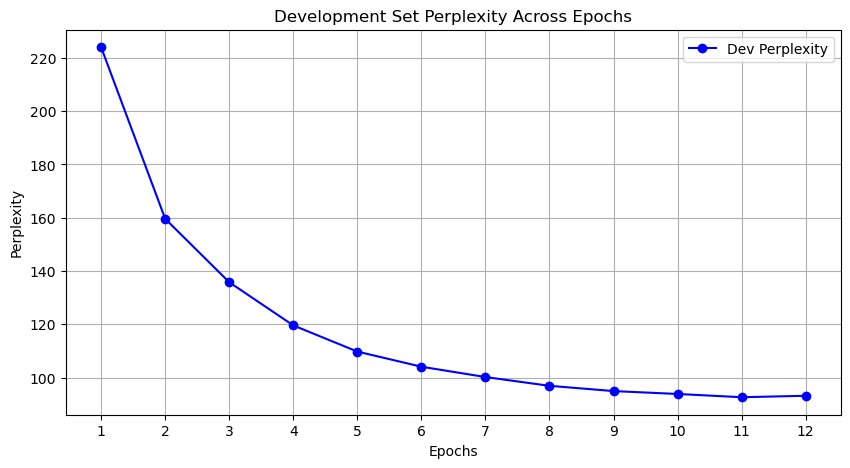

In [12]:
# Define the neural language model architecture
# Updated neural language model architecture
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob, bidirectional=True):
        super(LanguageModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout_prob, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x, (hidden, cell) = self.lstm(x)
        x = self.fc(x)
        return x

# Updated hyperparameters for more complexity
embedding_dim = 768  # Increased from 512
hidden_dim = 512     # Remains 512
num_layers = 4       # Increased from 3
dropout_prob = 0.5   # Adjusted as per requirement
learning_rate = 0.0003  # Fine-tuned learning rate
batch_size = 64      # Remains the same
bidirectional = True # Using a bidirectional LSTM

# Instantiate the model with the hyperparameters
model = LanguageModel(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob, bidirectional)

# Define loss function with L2 Regularization in the optimizer
criterion = nn.CrossEntropyLoss(ignore_index=vocab_dict['<PAD>'])
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5) 

# Define hyperparameters
# embedding_dim = 256  
# hidden_dim = 512     
# learning_rate = 0.001
# batch_size = 64
# num_layers = 2
# dropout_prob = 0.5 

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=vocab_dict['<PAD>'])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with early stopping
num_epochs = 12
train_losses = []
dev_perplexities = []
min_delta = 0.01
patience = 3
wait = 0
best_perplexity = float('inf')
best_model = None

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            outputs = outputs.view(-1, vocab_size)
            targets = targets.view(-1)
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            pbar.update(1)

    train_losses.append(epoch_loss / len(train_loader))
    dev_perplexity = calculate_perplexity(model, dev_loader, vocab_dict['<PAD>'], vocab_dict['<EDGE>'])
    dev_perplexities.append(dev_perplexity)
    print(f"Epoch {epoch + 1}: Dev Perplexity: {dev_perplexity}")

    # Early stopping check
    if dev_perplexity < best_perplexity - min_delta:
        best_perplexity = dev_perplexity
        wait = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        wait += 1
        if wait >= patience:
            print(f"Stopping early at epoch {epoch + 1}")
            # Load the best model for further processing
            model.load_state_dict(torch.load('best_model.pth'))
            break

# Load the best model if early stopping was triggered and if we are not in the last epoch
if epoch < num_epochs - 1 and best_model is not None:
    model.load_state_dict(torch.load('best_model.pth'))

# Plotting the perplexity for the development set only
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(dev_perplexities) + 1), dev_perplexities, label='Dev Perplexity', color='blue', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Development Set Perplexity Across Epochs')
plt.legend()
plt.grid(True)
plt.xticks(range(1, len(dev_perplexities) + 1))  
plt.show()

4.2) Now measure the space saving amount of the trained model on the test text.
Also check that when you decompress the compressed test text, you get exactly the same string as the test text.

Note: You may need to strip off the new line character from the end of the test text when comparing it to the decompressed text.

In [13]:
# Load the best model for evaluation
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

# Compress the test text
compressed_test_text = compress_text(test_set_string, model, vocab_dict, index_to_token)

# Calculate the space saving
space_saving = calculate_space_saving(test_set_string, model, vocab_dict, index_to_token)
print(f"Space saving: {space_saving * 100:.2f}%")

# Decompress the compressed text
decompressed_test_text = decompress_text(compressed_test_text, model, vocab_dict, index_to_token)

# Compare the original and decompressed texts
if test_set_string.strip() == decompressed_test_text.strip():
    print("Decompression successful: Original and decompressed texts are the same.")
else:
    print("Decompression mismatch: There is a difference between the original and decompressed texts.")

Space saving: 2.99%
Decompression successful: Original and decompressed texts are the same.


In [14]:
# Define a sample sentence to compress and decompress
sample_sentence = "6 % of all households were made up of individuals , and 1 5 ."

# Compress the sample sentence using the trained model
compressed_sample = compress_text(sample_sentence, model, vocab_dict, index_to_token)
print(f"Compressed Sample Sentence: {compressed_sample}")

# Decompress the compressed sample sentence
decompressed_sample = decompress_text(compressed_sample, model, vocab_dict, index_to_token)
print(f"Decompressed Sample Sentence: {decompressed_sample}")

Compressed Sample Sentence: 6 % X all households were made up X individuals , X X 5 X
Decompressed Sample Sentence: 6 % of all households were made up of individuals , and 1 5 .


4.3) Now you need to analyse the model's output.
Split the test text into sentences and compress each individual sentence.
Print out the top 5 most compressed sentences and the top 5 least compressed sentences according to the space saving metric together with the compressed sentences.

In [15]:
# Split the test text into sentences
sentences = sent_tokenize(test_set_string)

# Compress each sentence and calculate space saving
sentence_compressions = []
for sentence in sentences:
    compressed_sentence = compress_text(sentence, model, vocab_dict, index_to_token)
    space_saving = calculate_space_saving(sentence, model, vocab_dict, index_to_token)  # Updated function call
    sentence_compressions.append((sentence, compressed_sentence, space_saving))

# Sort the sentences by space saving
sentence_compressions.sort(key=lambda x: x[2], reverse=True)

# Extract top 5 most and least compressed sentences
top_5_most_compressed = sentence_compressions[:5]
top_5_least_compressed = sentence_compressions[-5:]

# Print out the top 5 most compressed sentences
print("Top 5 Most Compressed Sentences:\n")
for original, compressed, saving in top_5_most_compressed:
    print(f"Original: {original}\nCompressed: {compressed}\nSpace Saving: {saving * 100:.2f}%\n")

print("-"*125)

# Print out the top 5 least compressed sentences
print("Top 5 Least Compressed Sentences:\n")
for original, compressed, saving in top_5_least_compressed:
    print(f"Original: {original}\nCompressed: {compressed}\nSpace Saving: {saving * 100:.2f}%\n")

Top 5 Most Compressed Sentences:

Original: the average household size was 2 .
Compressed: X average household X X 2 .
Space Saving: 20.59%

Original: the same 5 .
Compressed: X same 5 .
Space Saving: 16.67%

Original: he qualified to represent israel at the 2 0 2 0 summer olympics .
Compressed: he qualified X represent israel at X 2 X 2 X summer X X
Space Saving: 15.38%

Original: he competed in the individual foil events at the 2 0 1 2 summer olympics , 2 0 0 8 summer olympics and 2 0 0 4 summer olympics .
Compressed: he competed X X individual foil events at X 2 X X 2 summer X , 2 X X 8 summer X and 2 X X 4 summer olympics X
Space Saving: 14.84%

Original: at the 2 0 0 6 census , its population was 8 1 , in 1 9 families .
Compressed: at X X X 0 6 X X its population X 8 1 X in X X families .
Space Saving: 13.64%

-----------------------------------------------------------------------------------------------------------------------------
Top 5 Least Compressed Sentences:

Original: he

4.4) Is the reason for whether a sentence is compressible or not due to its similarity to the train set (a sentence that is similar to one in the train set would be easier to predict and thus more tokens will be compressed)?
Find out the answer to this by doing the following:

Extract all the trigrams from the train set (you can use `nltk.trigrams` to do this).
For each sentence in the test set, count how many of its trigrams are also found in the train set.
Turn this count into a domain similarity measure by dividing it by the number of trigrams in the test sentence.

Note: In order for this fraction to be meaningful from the language model's point of view, the edge token must be added to the front of the test sentences and out-of-vocabulary tokens must be replaced with the unknown token.

Create a list that maps each sentence's domain similarity to its space saving amount.
Plot a scatter plot showing how the domain similarity measure relates to the space saving amount of each test sentence.
If there is a correlation between these two measures, then the points in the scatter plot will form approximately into a straight line.

In [ ]:
# Assuming the necessary data structures and functions have been defined in the notebook, such as `train_set`,
# `test_set`, `vocab_dict`, and the functions `compress_text` and `calculate_space_saving`,
# the following code can be written to calculate the domain similarity and space saving of each sentence.

# from nltk import trigrams
# from nltk.tokenize import word_tokenize
# from collections import Counter
# 
# # Function to replace out-of-vocabulary tokens with the unknown token
# def replace_oov_tokens(sentence, vocab):
#     return [token if token in vocab else '<UNK>' for token in sentence]
# 
# # Function to calculate domain similarity
# def calculate_domain_similarity(test_sentence, train_trigrams):
#     test_trigrams = list(trigrams(test_sentence))
#     common_trigrams = sum(1 for trigram in test_trigrams if trigram in train_trigrams)
#     return common_trigrams / len(test_trigrams) if test_trigrams else 0
# 
# # Add the edge token to the front of the test sentences
# test_set_with_edge = ['<EDGE> ' + sentence for sentence in test_set]
# 
# # Replace out-of-vocabulary tokens in the test sentences
# test_set_preprocessed = [replace_oov_tokens(word_tokenize(sentence), vocab_dict) for sentence in test_set_with_edge]
# 
# # Extract all trigrams from the train set
# train_sentences_tokenized = [word_tokenize(sentence) for sentence in train_set]
# train_trigrams_set = set(trigram for sentence in train_sentences_tokenized for trigram in trigrams(sentence))
# 
# # Calculate domain similarity and space saving for each test sentence
# domain_similarity_space_saving = []
# 
# for sentence in test_set_preprocessed:
#     domain_similarity = calculate_domain_similarity(sentence, train_trigrams_set)
#     compressed_sentence = compress_text(sentence, model, vocab_dict, index_to_token)
#     space_saving = calculate_space_saving(' '.join(sentence), model, vocab_dict, index_to_token)
#     domain_similarity_space_saving.append((domain_similarity, space_saving))
# 
# # Now, let's plot the scatter plot
# import matplotlib.pyplot as plt
# 
# # Unzip the list into two separate lists
# domain_similarities, space_savings = zip(*domain_similarity_space_saving)
# 
# plt.figure(figsize=(10, 5))
# plt.scatter(domain_similarities, space_savings, alpha=0.5)
# plt.xlabel('Domain Similarity')
# plt.ylabel('Space Saving Amount')
# plt.title('Domain Similarity vs Space Saving Amount')
# plt.grid(True)
# plt.show()

4.5) The scatter plot should not have created a straight line and should show a lot of bias towards very low space saving amounts, regardless of domain similarity.
Why is domain similarity not enough for explaining the compressability?

## 5) Conclusions (10%)

Write the following conclusions:

5.1) What is a simple change in the compression algorithm that can be made to increase compression?
Do not suggest any fundamental changes; the algorithm must still work by predicting missing tokens.

5.2) Write, in less than 300 words, your interpretation of the results and how you think the model could perform better.
You should talk about things like overfitting/underfitting and whether the model is learning anything deep about English sentences.